In [1]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

env: DDE_BACKEND=tensorflow


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
from models.domains import NewtonianParallelPlane
from models.rheology import NewtonianFluid
from models.PINN import PINNParameters
from models.neural_network import NeuralNetwork, ADAMOptimizer, LBFGSOptimizer
from models.data import TrainingData, NeuralNetworkModel

rheology = NewtonianFluid(mu=1, density=1)
domain = NewtonianParallelPlane(distance=1, length=1, inlet_velocity=1, rheology=rheology)
boundary_conditions = domain.build_boundary_conditions()
neural_network = NeuralNetwork(
    adam_optimizer=ADAMOptimizer(iterations=100, report_frequency=100),
    LBFGS_optimizer=LBFGSOptimizer(max_iterations=100, report_frequency=100)
)
pinn_parameters = PINNParameters(
    domain_points=100,
    boundary_points=100,
    number_of_test=100, 
)
net = neural_network.build_net()
training_data = TrainingData(domain=domain, boundary_condition_list=[v for v in boundary_conditions.values()], pinn_parameters=pinn_parameters)
model = NeuralNetworkModel(data=training_data.data, net=net)

<function matplotlib.pyplot.show(close=None, block=None)>

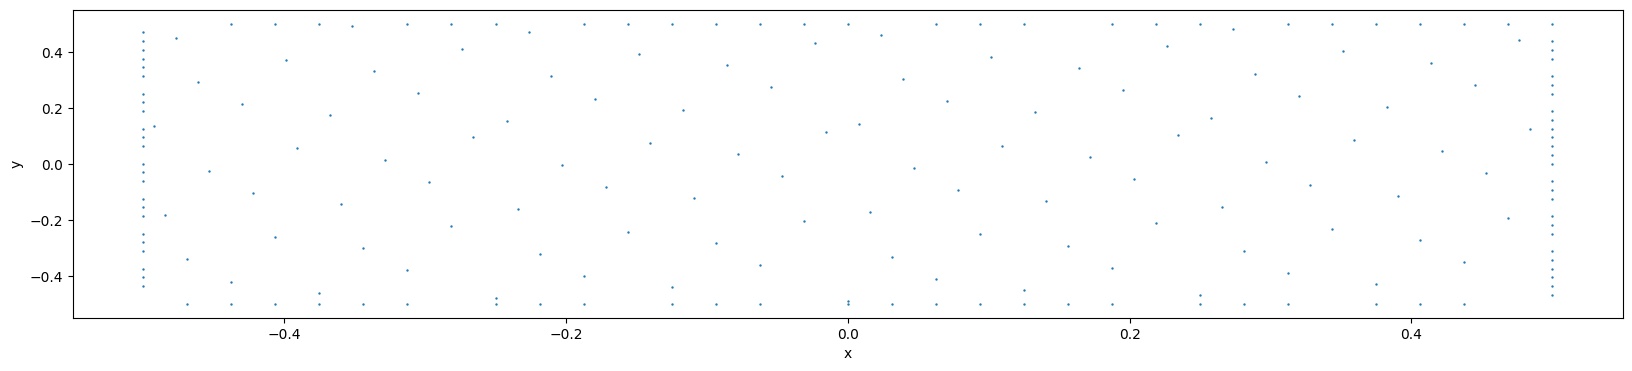

In [3]:
plt.figure(figsize=(20,4))
plt.scatter(training_data.data.train_x_all[:,0],training_data.data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [4]:
import pathlib

model.compile_ADAM_model(learning_rate=neural_network.adam_optimizer.learning_rate)
losshistory, train_state = model.train_model(
    iterations=neural_network.adam_optimizer.iterations,
    display_frequency=neural_network.adam_optimizer.report_frequency
)
adam_output_path = pathlib.Path("./out/adam/model_state")
adam_output_path.parent.mkdir(parents=True, exist_ok=True)
model.export_model(output_path=adam_output_path)

Compiling model...
'compile' took 0.000539 s

Training model...



c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function BoundaryConditionBuilder.inlet_boundary.<locals>.<lambda> at 0x0000022231797370>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function BoundaryConditionBuilder.inlet_boundary.<locals>.<lambda> at 0x0000022231797370>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function BoundaryConditionBuilder.inlet_boundary.<locals>.<lambda> at 0x00000222317976D0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning

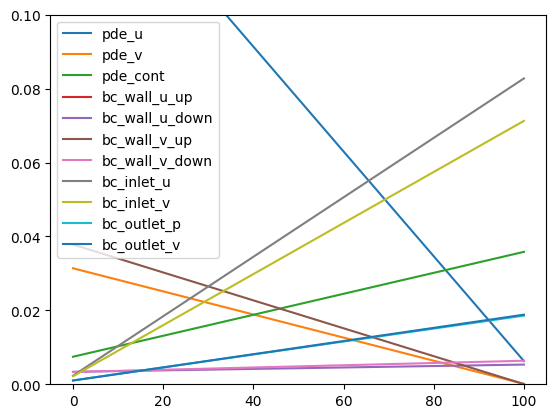

In [5]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up", "bc_wall_u_down", "bc_wall_v_up", "bc_wall_v_down", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [6]:
model.compile_LBFGS_model()
losshistory, train_state = model.train_model(
    iterations=neural_network.LBFGS_optimizer.max_iterations, 
    display_frequency=neural_network.LBFGS_optimizer.report_frequency
)
LBFGS_output_path = pathlib.Path("./out/LBFGS/model_state")
LBFGS_output_path.parent.mkdir(parents=True, exist_ok=True)
model.export_model(output_path=LBFGS_output_path)

Compiling model...
'compile' took 0.058435 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
100       [1.08e-02, 1.76e-04, 3.39e-02, 2.38e-01, 5.33e-03, 5.20e-05, 6.37e-03, 8.28e-02, 7.13e-02, 1.86e-02, 1.88e-02]    [6.28e-03, 1.18e-04, 3.58e-02, 2.38e-01, 5.33e-03, 5.20e-05, 6.37e-03, 8.28e-02, 7.13e-02, 1.86e-02, 1.88e-02]    []  


KeyboardInterrupt: 

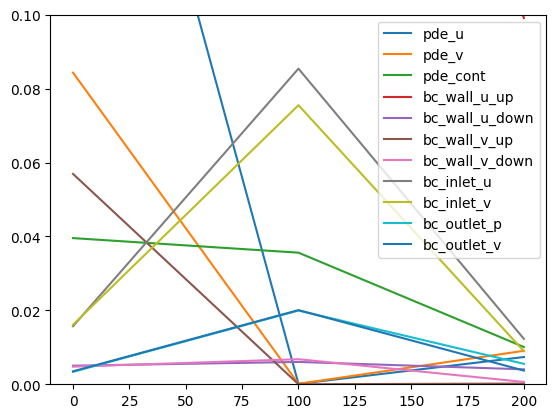

In [ ]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up", "bc_wall_u_down", "bc_wall_v_up", "bc_wall_v_down", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [ ]:
samples= domain.geometry.random_points(500000)
result = model.predict(samples)

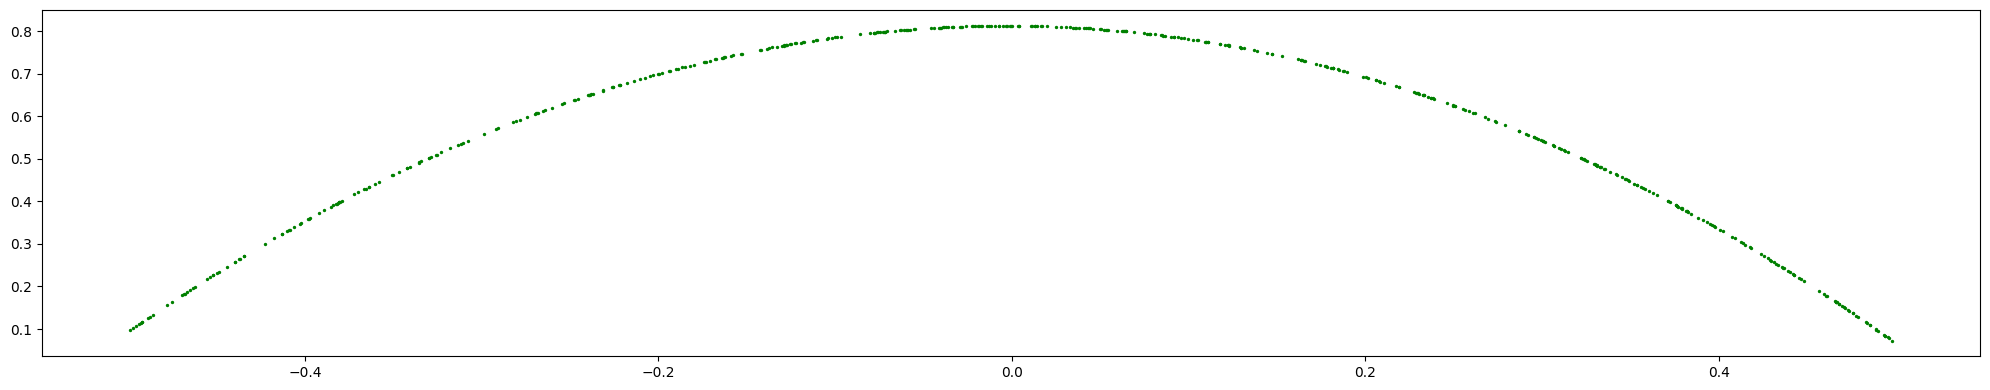

In [ ]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > (domain.distance/2 - 0.001)) & (samples[:,0] <= domain.distance/2))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -(domain.distance/2 + 0.001)) & (samples[:,0] >= -domain.distance/2))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

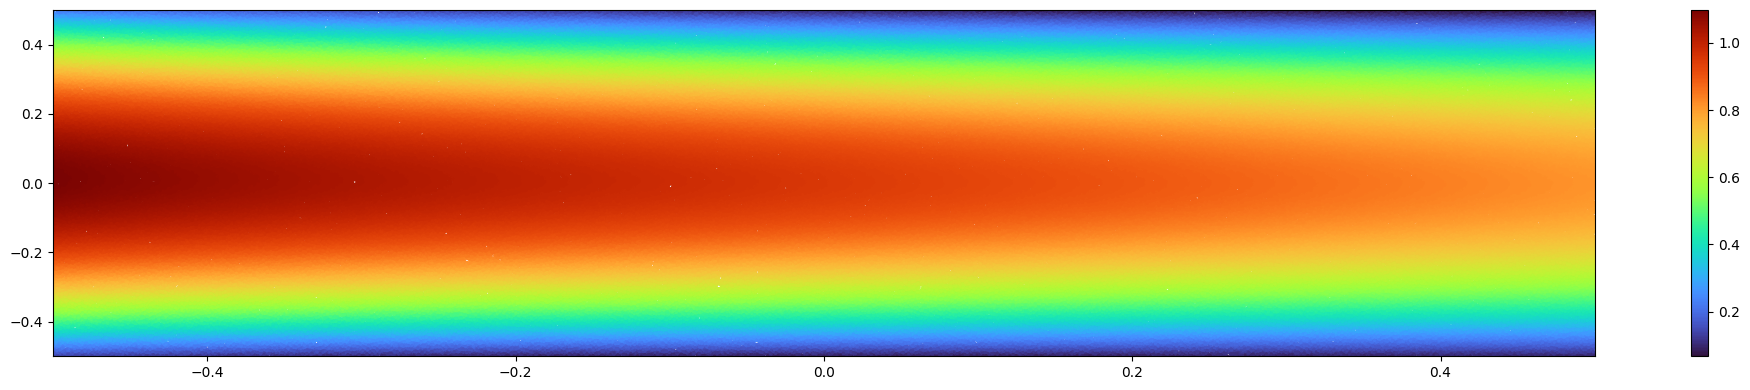

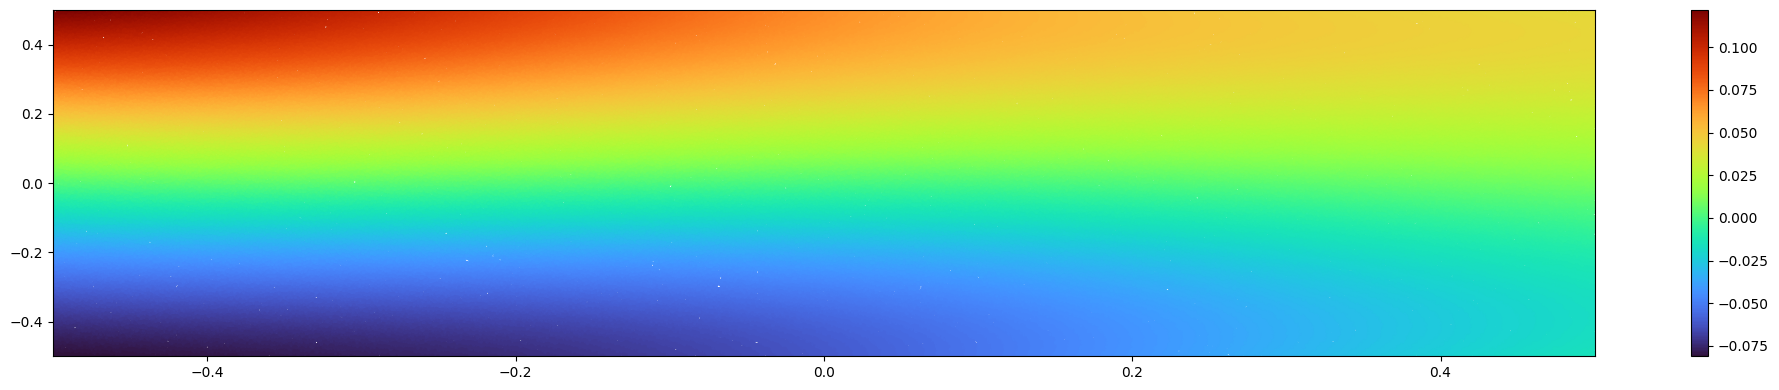

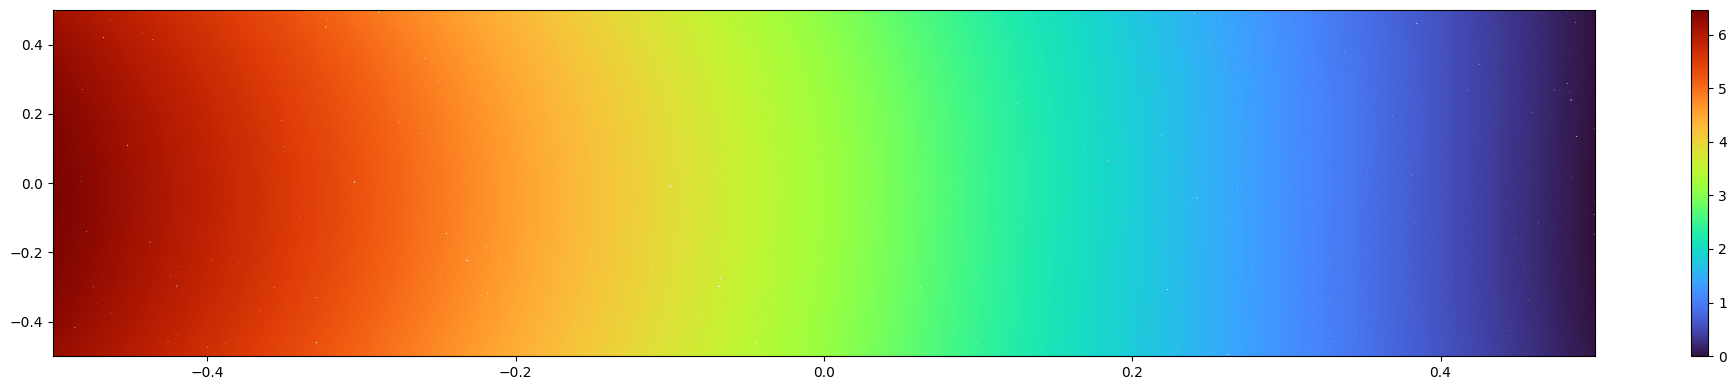

In [ ]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'turbo',
               s=2)
    plt.colorbar()
    plt.clim([result[:,idx].min(), result[:,idx].max()])
    plt.xlim((-domain.length/2, domain.length/2))
    plt.ylim((-domain.distance/2, domain.distance/2))
    plt.tight_layout()
    plt.show()

# Analytical solution

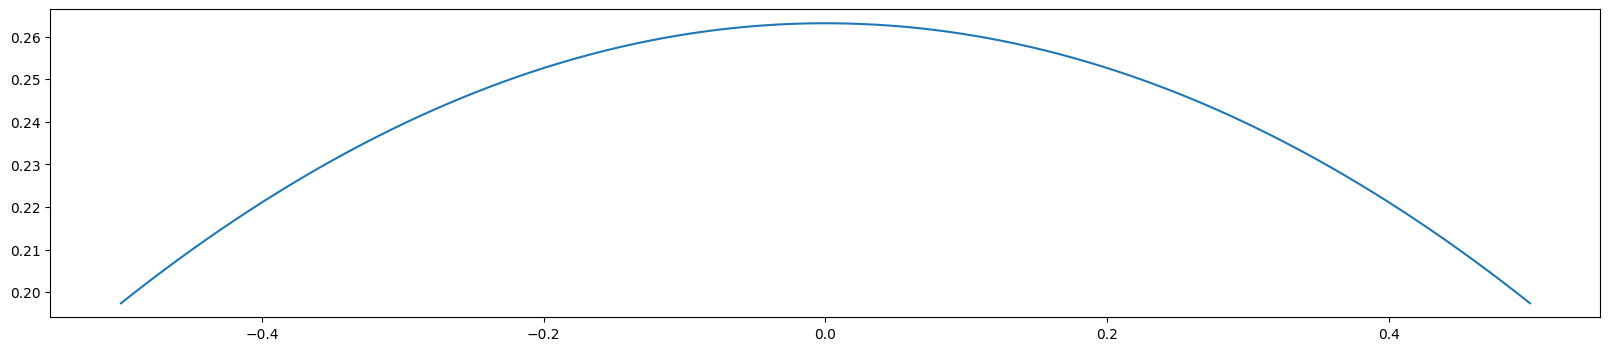

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dp_dx = -1.05263157895 # Pa / m

k = 0.5
R = 1
a = R
b = k * R
r = np.linspace(-0.5, 0.5, 100)
u_analytic = (1 / (4 * rheology.mu)) * (- dp_dx)  * (R ** 2 - r ** 2)
# u_analytic = (1 / (4 * mu)) * (- dp_dx)  * (a ** 2 - r ** 2 + ((a ** 2 - b ** 2) / np.log([a / b])[0] * np.log(a / r)))

plt.figure(figsize=(20,4))
plt.plot(r, u_analytic)
plt.show()